In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [10]:
# Define improved transformations - less aggressive augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((56, 56)),
    transforms.RandomCrop(48, padding=4),  # Reduced padding
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),  # Reduced rotation
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Less translation/scaling
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Reduced color jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),  # No random crop for validation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load dataset
train_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/train", transform=transform_train)
loaded_train = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

validation_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/validation", transform=transform_val)
loaded_validation = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


In [11]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=True),  # Extra conv layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=True),  # Extra conv layer
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=True),  # Extra conv layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=True),  # Extra conv layer
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*3*3, 512),
            nn.ReLU(),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x


In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [15]:
# Initialize model, loss, and optimizer with more appropriate settings
model = EmotionCNN().to(device)

# Use a combination of CrossEntropy and Focal Loss
criterion = FocalLoss(gamma=1.5)  # Adjust gamma to focus on harder examples

# Optimizer with different hyperparameters
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Learning rate scheduler with warmup
def get_lr_scheduler(optimizer):
    lambda1 = lambda epoch: min((epoch + 1) / 5.0, 1.0) if epoch < 5 else 0.5 ** ((epoch - 5) // 5)
    return lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

scheduler = get_lr_scheduler(optimizer)

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_targets


In [16]:
def mixup_data(x, y, alpha=0.2):
    '''Creates mixed examples using mixup augmentation'''
    batch_size = x.size()[0]
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    # Create batch indices and shuffle them
    index = torch.randperm(batch_size).to(device)
    
    # Mix the samples
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''Calculates the loss with mixup'''
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [17]:
def train_with_validation(model, optimizer, scheduler, epochs=50):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    patience = 10
    counter = 0
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}")
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training phase
        model.train()
        for i, (images, labels) in enumerate(loaded_train):
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            
            # Apply mixup with reduced alpha for emotion recognition
            if epoch < 30:  # Use mixup only in earlier epochs
                images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.1)
                optimizer.zero_grad()
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            
            # For accuracy calculation with mixup, we use the original labels
            correct += (predicted == labels).sum().item()
            
            # Print batch progress every 20 batches
            if (i + 1) % 20 == 0:
                print(f"  Batch {i+1}/{len(loaded_train)}, Loss: {loss.item():.4f}")
        
        train_accuracy = 100 * correct / total
        epoch_loss = running_loss / len(loaded_train)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(train_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        
        # Validation phase
        val_accuracy, _, _ = evaluate_model(model, loaded_validation)
        history['val_acc'].append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.2f}%")
        
        # Update learning rate
        if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_accuracy)
        else:
            scheduler.step()
            
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_emotion_model.pth')
            print(f"Model saved with validation accuracy: {best_val_acc:.2f}%")
            counter = 0
        else:
            counter += 1
            
        # Early stopping
        if counter >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break
            
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    return history

In [18]:
def predict_emotion(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        return predicted.item()

# Function to load the saved model
def load_saved_model(path='best_emotion_model.pth'):
    model = EmotionCNN(num_classes=7).to(device)
    model.load_state_dict(torch.load(path))
    return model

print("Starting training...")
# Assuming loaded_train and loaded_validation are already defined
training_history = train_with_validation(model, optimizer, scheduler, epochs=50)
print("Training complete!")


Starting training...
Epoch: 1
  Batch 20/451, Loss: 1.4495
  Batch 40/451, Loss: 1.4555
  Batch 60/451, Loss: 1.4013
  Batch 80/451, Loss: 1.3214
  Batch 100/451, Loss: 1.3312
  Batch 120/451, Loss: 1.3178
  Batch 140/451, Loss: 1.3819
  Batch 160/451, Loss: 1.4310
  Batch 180/451, Loss: 1.1952
  Batch 200/451, Loss: 1.3635
  Batch 220/451, Loss: 1.3081
  Batch 240/451, Loss: 1.2774
  Batch 260/451, Loss: 1.2708
  Batch 280/451, Loss: 1.0507
  Batch 300/451, Loss: 1.1563
  Batch 320/451, Loss: 1.2144
  Batch 340/451, Loss: 1.0788
  Batch 360/451, Loss: 1.4389
  Batch 380/451, Loss: 1.2839
  Batch 400/451, Loss: 1.2853
  Batch 420/451, Loss: 1.1757
  Batch 440/451, Loss: 1.1455
Epoch 1/50, Loss: 1.2815, Train Accuracy: 25.49%
Validation Accuracy: 39.43%
Current learning rate: 0.000200
Model saved with validation accuracy: 39.43%
Epoch: 2
  Batch 20/451, Loss: 1.3201
  Batch 40/451, Loss: 1.4719
  Batch 60/451, Loss: 1.1488
  Batch 80/451, Loss: 1.2665
  Batch 100/451, Loss: 1.0904
  Bat

KeyboardInterrupt: 

Target label: neutral


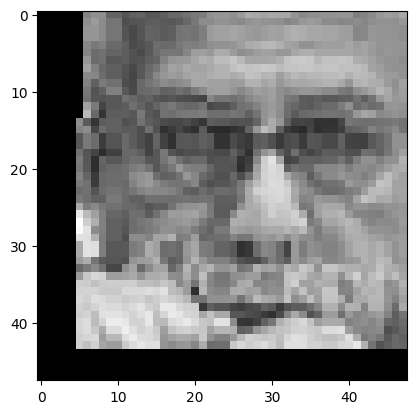

In [ ]:
# Visualization setup
dataiter = iter(loaded_train)
images, labels = next(dataiter)
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display a random image and its label
random_idx = random.randint(0, 63)
print("Target label:", expression[int(labels[random_idx].cpu().numpy())])
plt.imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
plt.show()


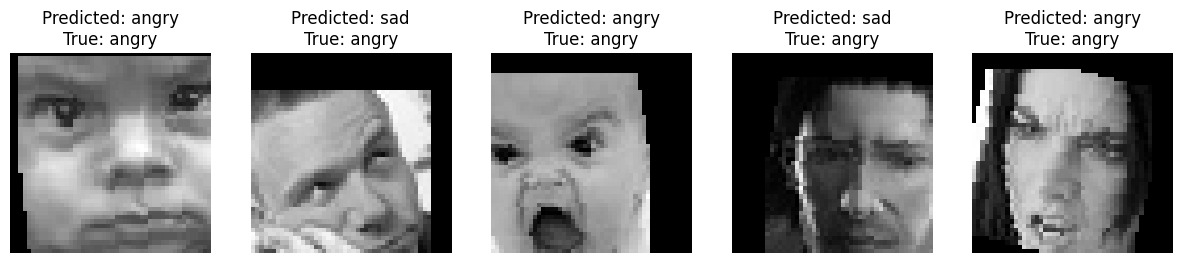

In [ ]:
# Evaluate the model and make predictions on 5 random images
model.eval()
dataiter = iter(loaded_validation)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display 5 random images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    random_idx = random.randint(0, len(images) - 1)
    axes[i].imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    axes[i].set_title(f"Predicted: {expression[int(predicted[random_idx].cpu().numpy())]}\nTrue: {expression[int(labels[random_idx].cpu().numpy())]}")
    axes[i].axis('off')
plt.show()